In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## data prep

Read in raw csv, remove NULLs and unneeded/unhelpful fields

In [2]:
df = pd.read_csv('sleepdata.csv', sep=";")
df[df['Sleep Notes'].notnull() | df['Wake up'].notnull()]  # just taking a look

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
52,2016-05-03 23:06:45,2016-05-04 08:18:49,95%,9:12,NaN,Worked out,0,3494
55,2016-05-06 23:58:42,2016-05-07 08:46:02,99%,8:47,NaN,Worked out,0,2477
57,2016-05-09 00:08:14,2016-05-09 08:52:15,86%,8:44,NaN,Worked out,0,3391
61,2016-05-15 00:44:18,2016-05-15 09:43:58,85%,8:59,NaN,Worked out,0,2143
88,2016-06-12 23:43:36,2016-06-13 08:02:03,63%,8:18,NaN,Ate late,0,3793


Drop Wake up, Sleep Notes, and Heart rate: not needed or incomplete data

In [3]:
df = df[['Start','End','Sleep quality','Time in bed','Activity (steps)']]

In [4]:
df.dtypes

Start               object
End                 object
Sleep quality       object
Time in bed         object
Activity (steps)     int64
dtype: object

#### Clean up fields and create calc'd fields

A number of fields need leanup and a number of calc'd fields are created for experimentation (i.e. time in min, year/day/etc as int, etc)

In [5]:
# adjusted features
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])

In [6]:
# added feature calcs
df['Time in bed (min)'] = df['Time in bed'].str.split(':')\
                            .apply(lambda x: int(x[0])*60 + int(x[1]))
df['Time in bed (hr)'] = df['Time in bed'].str.split(':')\
                            .apply(lambda x: (int(x[0])*60 + int(x[1]))/60)
df['Start hour (as float)'] = df['Start'].dt.hour + \
    df['Start'].dt.minute.apply(lambda x: (x//15 + (1 if x%15 >= 7.5 else 0))/4)
df['End hour (as float)'] = df['End'].dt.hour + \
    df['End'].dt.minute.apply(lambda x: (x//15 + (1 if x%15 >= 7.5 else 0))/4)
df['Hour (as float)'] = df['End hour (as float)'] - df['Start hour (as float)'].apply(lambda x: x if x < 12 else -(24 - x))
df['Rel start hour (as float)'] = df['Start hour (as float)'].apply(lambda x: x if x < 12 else -(24 - x))
df['Sleep quality (dec)'] = df['Sleep quality'].str.replace('%','').apply(lambda x: int(x)/100)

In [7]:
# remove bad record(s)
df = df.drop(df[df['End hour (as float)'] > 20].index) # bad records (woke up before midnight)
df = df.drop(df[df['End hour (as float)'] < 2].index) # bad record (woke up before 2 am)

# remove sleep quality == 0 and activity == 0
df.drop(df[df['Sleep quality (dec)'] == 0].index, inplace=True)
df.drop(df[df['Activity (steps)'] == 0].index, inplace=True)

In [8]:
# further parse datetime
df['Start (year)'] = df['Start'].dt.year 
df['Start (month)'] = df['Start'].dt.month
df['Start (day)'] = df['Start'].dt.day
df['Start (weekday)'] = df['Start'].dt.weekday

df['End (year)'] = df['End'].dt.year 
df['End (month)'] = df['End'].dt.month
df['End (day)'] = df['End'].dt.day
df['End (weekday)'] = df['End'].dt.weekday

In [9]:
df.dtypes

Start                        datetime64[ns]
End                          datetime64[ns]
Sleep quality                        object
Time in bed                          object
Activity (steps)                      int64
Time in bed (min)                     int64
Time in bed (hr)                    float64
Start hour (as float)               float64
End hour (as float)                 float64
Hour (as float)                     float64
Rel start hour (as float)           float64
Sleep quality (dec)                 float64
Start (year)                          int64
Start (month)                         int64
Start (day)                           int64
Start (weekday)                       int64
End (year)                            int64
End (month)                           int64
End (day)                             int64
End (weekday)                         int64
dtype: object

## Exploratory Data Analysis

In [10]:
df.shape

(1165, 20)

In [11]:
df.head()

,Start,End,Sleep quality,Time in bed,Activity (steps),Time in bed (min),Time in bed (hr),Start hour (as float),End hour (as float),Hour (as float),Rel start hour (as float),Sleep quality (dec),Start (year),Start (month),Start (day),Start (weekday),End (year),End (month),End (day),End (weekday)
0,2016-02-28 23:53:41,2016-02-29 06:56:01,65%,7:02,3091,422,7.033333,24.00,7.00,7.0,-0.00,0.65,2016,2,28,6,2016,2,29,0
1,2016-03-03 01:01:53,2016-03-03 08:00:10,80%,6:58,951,418,6.966667,1.00,8.00,7.0,1.00,0.80,2016,3,3,3,2016,3,3,3
2,2016-03-04 00:50:01,2016-03-04 07:49:01,76%,6:59,1891,419,6.983333,0.75,7.75,7.0,0.75,0.76,2016,3,4,4,2016,3,4,4
3,2016-03-05 00:40:34,2016-03-05 06:46:50,61%,6:06,1839,366,6.100000,0.75,6.75,6.0,0.75,0.61,2016,3,5,5,2016,3,5,5
4,2016-03-06 00:34:48,2016-03-06 08:58:55,81%,8:24,4269,504,8.400000,0.50,9.00,8.5,0.50,0.81,2016,3,6,6,2016,3,6,6


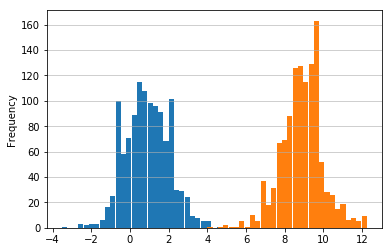

In [12]:
df['Rel start hour (as float)'].plot.hist(bins=30, rwidth=.95)
df['End hour (as float)'].plot.hist(bins=30, rwidth=.95)
plt.grid(axis='y', alpha=0.75)


In [13]:
df = df.drop(df[df['End hour (as float)'] > 20].index)

In [45]:
df.sort_values(by='Start', ascending=False).head()

,Start,End,Sleep quality,Time in bed,Activity (steps),Time in bed (min),Time in bed (hr),Start hour (as float),End hour (as float),Hour (as float),Rel start hour (as float),Sleep quality (dec),Start (year),Start (month),Start (day),Start (weekday),End (year),End (month),End (day),End (weekday)
1192,2019-10-19 23:35:02,2019-10-20 09:00:05,95%,9:25,4124,565,9.416667,23.50,9.00,9.50,-0.50,0.95,2019,10,19,5,2019,10,20,6
1191,2019-10-19 01:24:18,2019-10-19 09:44:32,91%,8:20,3920,500,8.333333,1.50,9.75,8.25,1.50,0.91,2019,10,19,5,2019,10,19,5
1190,2019-10-17 23:37:07,2019-10-18 08:07:49,98%,8:30,3584,510,8.500000,23.50,8.00,8.50,-0.50,0.98,2019,10,17,3,2019,10,18,4
1189,2019-10-17 00:17:01,2019-10-17 08:54:08,95%,8:37,3672,517,8.616667,0.25,9.00,8.75,0.25,0.95,2019,10,17,3,2019,10,17,3
1188,2019-10-15 23:40:11,2019-10-16 07:48:45,86%,8:08,3441,488,8.133333,23.75,7.75,8.00,-0.25,0.86,2019,10,15,1,2019,10,16,2


In [15]:
df.dtypes

Start                        datetime64[ns]
End                          datetime64[ns]
Sleep quality                        object
Time in bed                          object
Activity (steps)                      int64
Time in bed (min)                     int64
Time in bed (hr)                    float64
Start hour (as float)               float64
End hour (as float)                 float64
Hour (as float)                     float64
Rel start hour (as float)           float64
Sleep quality (dec)                 float64
Start (year)                          int64
Start (month)                         int64
Start (day)                           int64
Start (weekday)                       int64
End (year)                            int64
End (month)                           int64
End (day)                             int64
End (weekday)                         int64
dtype: object

## date/time and sleep quality

scatterplots of sleep quality as a function of various date/time vars

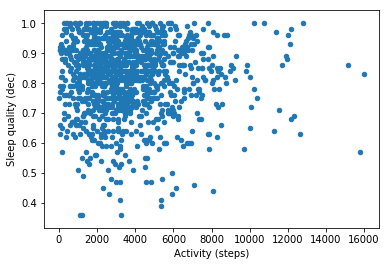

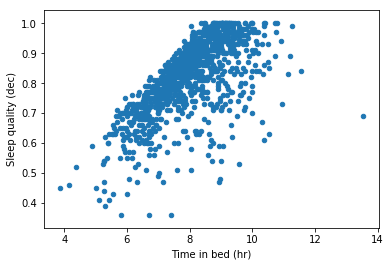

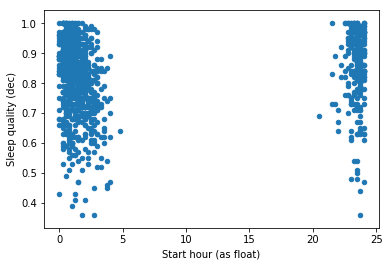

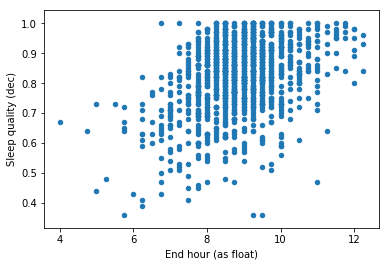

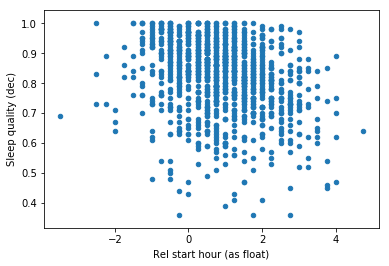

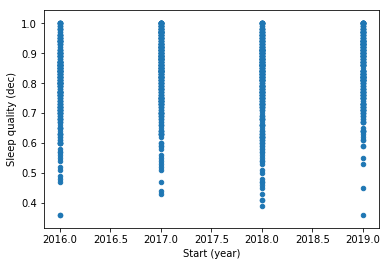

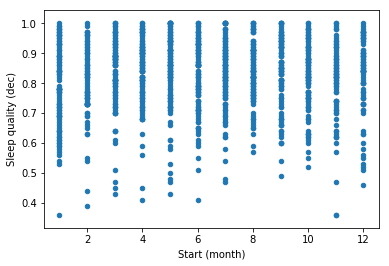

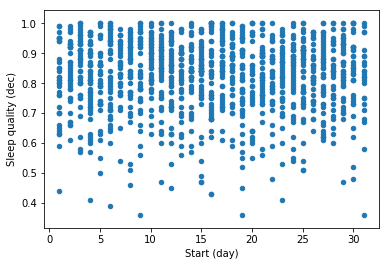

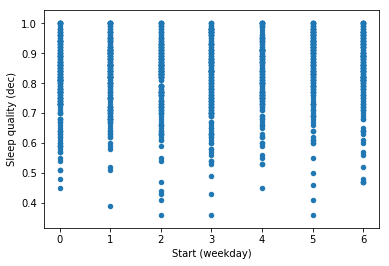

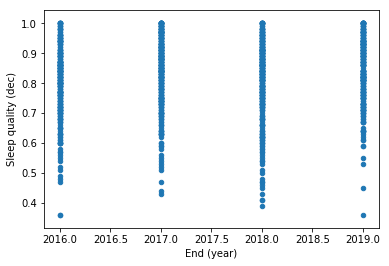

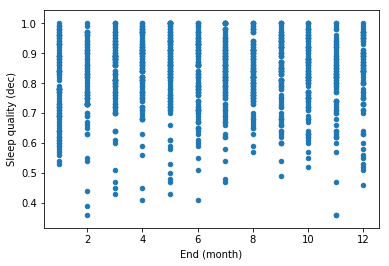

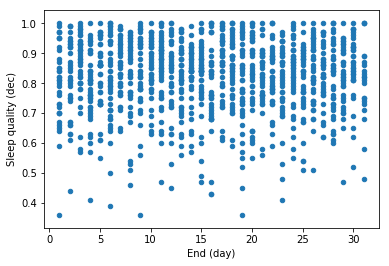

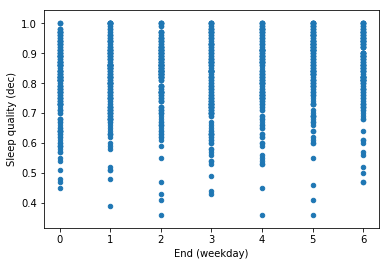

In [16]:
for col in df.columns:
    if df[col].dtype in [np.int64, np.float64] \
        and col not in ['Time in bed (min)', 'Sleep quality (dec)','Hour (as float)']:
        df.plot.scatter(x=col, y='Sleep quality (dec)')

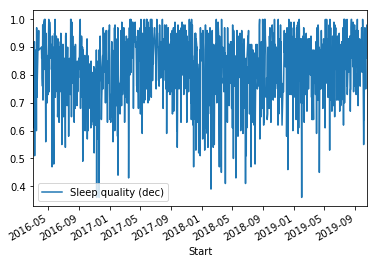

In [17]:
df.plot.line(x='Start', y='Sleep quality (dec)')

### pandas profiling

In [18]:
import pandas_profiling as pp

pp.ProfileReport(df)

Number of variables,21
Number of observations,1165
Total Missing (%),0.0%
Total size in memory,191.2 KiB
Average record size in memory,168.1 B
Numeric,11
Categorical,2
Boolean,0
Date,2
Text (Unique),0
Rejected,6


## create train/test

In [19]:
exclude_ls = \
['Start',
 'End',
 'Sleep quality',
 'Time in bed',
 'Hour',
 'Hour (as float)',
 'Time in bed (min)',
 'Rel start hour (as float)',
 'Start (year)',
 'Start (month)',
 'Start (day)',
 'End (year)',
 'End (month)',
 'End (day)',
 'End (weekday)',
 'Activity (steps)'
]  # Activity (steps) is actually quite statistically insignificant to sleep quality... (!)

df_ml = df[df.columns[~df.columns.isin(exclude_ls)]]
df_ml.head()

,Time in bed (hr),Start hour (as float),End hour (as float),Sleep quality (dec),Start (weekday)
0,7.033333,24.00,7.00,0.65,6
1,6.966667,1.00,8.00,0.80,3
2,6.983333,0.75,7.75,0.76,4
3,6.100000,0.75,6.75,0.61,5
4,8.400000,0.50,9.00,0.81,6


In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_ml, test_size=0.3)
train.shape, test.shape

((815, 5), (350, 5))

In [21]:
TRAIN_X = train.loc[:,df_ml.columns!="Sleep quality (dec)"]
TRAIN_Y = train["Sleep quality (dec)"]
TEST_X = test.loc[:,df_ml.columns!="Sleep quality (dec)"]
TEST_Y = test["Sleep quality (dec)"]

In [22]:
type(TRAIN_X), type(TRAIN_Y), type(TEST_X), type(TEST_Y)

(pandas.core.frame.DataFrame,
 pandas.core.series.Series,
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [23]:
len(TRAIN_X), len(TRAIN_Y), len(TEST_X), len(TEST_Y)

(815, 815, 350, 350)

In [24]:
len(TRAIN_X.columns), len(TEST_X.columns)  # note: Series do not have .columns (only 1 col)

(4, 4)

## machine learning

### linear regression

In [25]:
INTERCEPT = False

In [26]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=INTERCEPT)
model.fit(TRAIN_X, TRAIN_Y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [27]:
model.score(TEST_X, TEST_Y), model.score(TRAIN_X, TRAIN_Y)

(0.22292045090649937, 0.45260520556824)

In [28]:
model.coef_, model.intercept_
# note that model coef and intercept are the same as in Summary...

(array([ 0.08459487, -0.00171574,  0.01753069,  0.00073757]), 0.0)

In [29]:
TEST_Y_predict = model.predict(TEST_X)

In [30]:
#list(TEST_Y), list(TEST_Y_predict)

In [31]:
# no idea why this is completely different from OLS...

# MSE is good...

from sklearn.metrics import mean_squared_error, r2_score

print("Mean squared error: %.2f"
      % mean_squared_error(TEST_Y, TEST_Y_predict))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' 
      % r2_score(TEST_Y, TEST_Y_predict))

print("Mean squared error: %.2f"
      % mean_squared_error(TRAIN_Y, model.predict(TRAIN_X)))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' 
      % r2_score(TRAIN_Y, model.predict(TRAIN_X)))

Mean squared error: 0.01
Variance score: 0.22
Mean squared error: 0.01
Variance score: 0.45


https://stackoverflow.com/questions/42033720/python-sklearn-multiple-linear-regression-display-r-squared

In [32]:
X = TRAIN_X
y = TRAIN_Y
yhat = model.predict(X)
SS_Residual = sum((y-yhat)**2)
SS_Total = sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
r_squared, adjusted_r_squared

(0.4526052055682409, 0.44990202139820756)

Text(0, 0.5, 'Predicted Response')

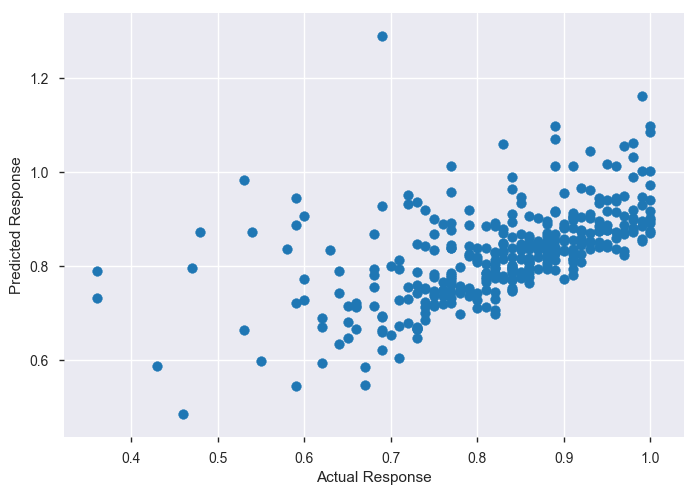

In [33]:
plt.scatter(TEST_Y, TEST_Y_predict)
plt.xlabel("Actual Response")
plt.ylabel("Predicted Response")

using statsmodels

In [34]:
import statsmodels.api as sm

if INTERCEPT:
    TRAIN_X = sm.add_constant(TRAIN_X)   #get same R^2 if constant added

result = sm.OLS(TRAIN_Y, TRAIN_X).fit()
print(result.mse_resid, result.mse_total, "\n")  # mse_resid = mean sq error above (ok)
result.summary()

0.008147432021113335 0.690878282208589 



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Sleep quality (dec)   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.988
Method:                  Least Squares   F-statistic:                 1.707e+04
Date:                 Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                         16:46:57   Log-Likelihood:                 805.67
No. Observations:                  815   AIC:                            -1603.
Df Residuals:                      811   BIC:                            -1585.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Time in bed (hr)          0.0846      0.004     21.048      0.000       0.077       0.092
Start hour (as float)    -0.0017      0.000     -3.841      0.000      -0.003      -0.001
End hour (as float)       0.0175      0.003      5.009      0.000       0.011       0.024
Start (weekday)           0.0007      0.002      0.460      0.646      -0.002       0.004
==============================================================================
Omnibus:                      201.157   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              454.514
Skew:                          -1.330   Prob(JB):                     2.01e-99
Kurtosis:                       5.512   Cond. No.                         24.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## random forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
model = RandomForestRegressor(n_estimators = 5000, random_state = 51)
model = model.fit(TRAIN_X, TRAIN_Y)

In [37]:
model.score(TRAIN_X, TRAIN_Y)

0.9286279827884448

In [38]:
model.score(TEST_X, TEST_Y)

0.29901609480794267

In [39]:
TEST_Y_predict = model.predict(TEST_X)

Text(0, 0.5, 'Predicted Response')

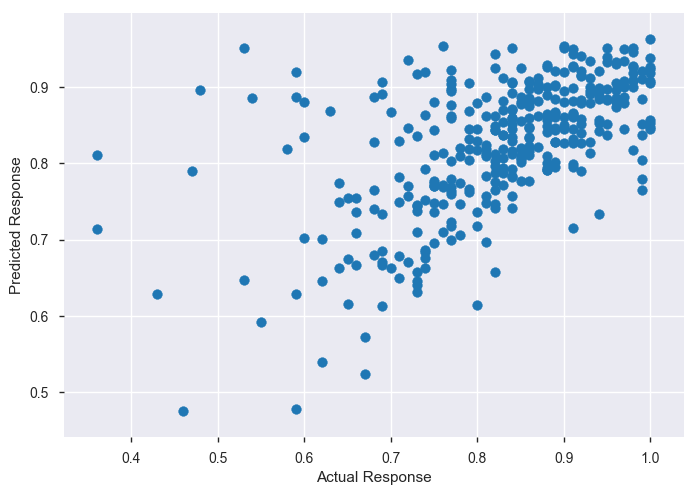

In [40]:
plt.scatter(TEST_Y, TEST_Y_predict)
plt.xlabel("Actual Response")
plt.ylabel("Predicted Response")

## logistic regression

In [41]:
# lbfgs
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=10000)  # tune max_iter hyperparameter to achieve convergence
model = model.fit(TRAIN_X, TRAIN_Y)

ValueError: Unknown label type: 'continuous'

## ridge regression

In [ ]:
from sklearn import linear_model

In [ ]:
model = linear_model.Ridge(alpha=.5)
model = model.fit(TRAIN_X, TRAIN_Y)
TEST_Y_predict = model.predict(TEST_X)

print(model.score(TRAIN_X, TRAIN_Y))

plt.scatter(TEST_Y, TEST_Y_predict)
plt.xlabel("Actual Response")
plt.ylabel("Predicted Response")

In [ ]:
# ???

model = linear_model.Lasso(alpha=0.5)
model = model.fit(TRAIN_X, TRAIN_Y)
TEST_Y_predict = model.predict(TEST_X)

print(model.score(TRAIN_X, TRAIN_Y))

plt.scatter(TEST_Y, TEST_Y_predict)
plt.xlabel("Actual Response")
plt.ylabel("Predicted Response")